# Code to train a vision encoder-decoder model
Warm-start a huggingface transformers vision encoder-decoder and then train it on chemistry ToC images + paper titles.

Informed by this tutorial:
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb


Check memory usage with !nvidia-smi (if running in a notebook, the kernel needs to be restarted to clear the memory)

In [ ]:
!nvidia-smi

For references on the seq2seq trainer to train this model see also: https://huggingface.co/course/chapter7/4?fw=pt

Initiate training dataframes from a csv and folder with training images

In [2]:
import pandas as pd
from ast import literal_eval
import os

# Load the csv
headings = ['title', 'file_name', 'Abstract']
df = pd.read_csv('data.csv', names = headings)

# Drop null values
df = df.mask(df.eq('None')).dropna()

# Get the image file names
df['file_name'] = df['file_name'].map(lambda x:x.split('/')[-1].split('.')[0]+'.png')

# Include only rows where image exists
root_dir = "<IMAGE_FOLDER>"
yes_image = df['file_name'].map(lambda x: os.path.exists(root_dir + x))
df = df[yes_image]

# Data was written as byte strings of the form b'string' - evaluate in python then decode to utf-8
df['title'] = df['title'].map(lambda x: literal_eval(x).decode('utf-8'))

# [Make train-test split]
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.001, random_state=42)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_df.head()

,title,file_name,Abstract
0,Unexpected Formation of NHC-Stabilized Hydrosi...,ja-2015-063665_0002.png,b'N-heterocyclic carbene (NHC)-stabilized hydr...
1,Genome-Based Deletion Analysis Reveals the Pre...,ja-2010-096682_0007.png,b'Xanthones are a class of molecules that bind...
2,Mechanistic Insights on Azide−Nitrile Cycloadd...,ja-2010-09700b_0002.png,b'The mechanism of the azide\xe2\x88\x92nitril...
3,Ruthenium-Catalyzed Olefin Cross-Metathesis wi...,ja-2015-033426_0009.png,b'This Communication describes a successful ol...
4,Optimizing Sensitization Processes in Dinuclea...,ja-2011-06806t_0003.png,b'This work illustrates a simple approach for ...


Write a dataset class that returns both image and text. Make the same changes to add padding token as seen in the gpt2 pretrainer notebook.

In [3]:
from torch.utils.data import Dataset
from PIL import Image

class JACSDataset(Dataset):
    def __init__(self, root_dir, df, text_processor, image_processor, max_target_len=128):
        self.root_dir = root_dir
        self.df = df
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + title
        file_name = self.df['file_name'][idx]
        title = self.df['title'][idx] + self.text_processor.eos_token

        # prepare image (resize & normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.image_processor(image, return_tensors="pt").pixel_values

        labels = self.text_processor(
            title,
            padding="max_length",
            max_length=self.max_target_len,
            truncation=True, # Does not auto-truncate
            ).input_ids

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding      


Initialise processors for images and text 

In [5]:
from transformers import BeitFeatureExtractor, GPT2Tokenizer

text_processor = GPT2Tokenizer.from_pretrained("gpt2", pad_token="<|pad|>")
image_processor = BeitFeatureExtractor.from_pretrained(("microsoft/beit-base-patch16-224-pt22k-ft22k"))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Downloading: 100%|██████████| 276/276 [00:00<00:00, 273kB/s]


Initialize our datasets

In [ ]:
train_dataset = JACSDataset(
    root_dir=root_dir,
    df=train_df,
    text_processor=text_processor,
    image_processor=image_processor, 
    max_target_len=128)

eval_dataset = JACSDataset(
    root_dir=root_dir,
    df=test_df,
    text_processor=text_processor,
    image_processor=image_processor,
    max_target_len=128)

print("Number of training samples:", len(train_dataset))
print("Number of eval samples:", len(eval_dataset))

Inspect examples of image and text

In [7]:
encoding = train_dataset[42]
for k,v in encoding.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
labels torch.Size([128])


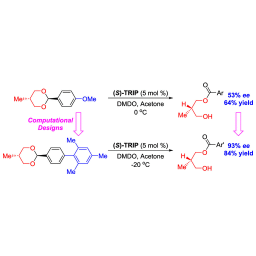

In [8]:
image = Image.open(train_dataset.root_dir + train_dataset.df['file_name'][42]).convert("RGB")
image

In [9]:
labels = encoding['labels']
label_str = text_processor.decode(labels, skip_special_tokens=True)
print(label_str)

Computational Design of Enhanced Enantioselectivity in Chiral Phosphoric Acid-Catalyzed Oxidative Desymmetrization of 1,3-Diol Acetals


Initialise a warm-started vision encoder decoder model from a pretrained vision model and a pretrained language model

In [ ]:
from transformers import BeitConfig, GPT2Config, VisionEncoderDecoderConfig, VisionEncoderDecoderModel

# load pretrained components
config_encoder = BeitConfig.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")
config_decoder = GPT2Config.from_pretrained("<LOCAL_PRETRAINED_MODEL_PATH>")

# set decoder config to causal lm
config_decoder.is_decoder = True
config_decoder.add_cross_attention = True

config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(config_encoder, config_decoder)

# initializing the model
model = VisionEncoderDecoderModel(config=config)

# Set various parameters:

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = text_processor.bos_token_id
model.config.pad_token_id = text_processor.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = text_processor.eos_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Specify arguments for the sequence-to-sequence trainer

In [11]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    num_train_epochs=30,
    predict_with_generate=True,
    evaluation_strategy="steps",
    save_strategy='steps',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, 
    output_dir="<OUTPUT_DIR>",
    logging_steps=2,
    save_steps=10000,
    eval_steps=1000
)


Choose an appropriate metric to evaluate the model. (See: https://huggingface.co/docs/evaluate/choosing_a_metric)

For this model, language metrics are appropriate as the output is text.

In [12]:
from datasets import load_metric
import numpy as np

metric = load_metric("meteor")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = text_processor.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, text_processor.pad_token_id)
    decoded_labels = text_processor.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"meteor": result["meteor"]}

    prediction_lens = [np.count_nonzero(pred != text_processor.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\y_w_u\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\y_w_u\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\y_w_u\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Initialize the trainer and run.

**Note:** this is better converted to a python script than a notebook, the cell output can become very long leading to crashes

In [ ]:
from transformers import default_data_collator

# Instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=image_processor,
    args=training_args,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

trainer.train()

To save the model to local folder

In [ ]:
model.save_pretrained("<LOCAL_FOLDER>")

Further thoughts on evaluation metrics
https://towardsdatascience.com/how-to-evaluate-text-generation-models-metrics-for-automatic-evaluation-of-nlp-models-e1c251b04ec1

* BLEU/Rouge/SacreBLEU - translation metrics
* Perplexity - lower is better
* LSA - latent semantic analysis - semantic similarity
* METEOR - less commonly used
* TER - translation edit rate
